## Imports

In [1]:
!pip install -q seaborn pandas 


[notice] A new release of pip available: 22.3.1 -> 23.2.1
[notice] To update, run: pip install --upgrade pip


In [2]:
from pathlib import Path
import ast
from collections import defaultdict

from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from stanza.models.common.doc import Sentence as StanzaSentence, Word as StanzaWord, Token as StanzaToken
from astred import Sentence, AlignedSentences

In [ ]:
import warnings
warnings.filterwarnings("error")

## Load data

In [3]:
DATASET_FOLDER = Path() / '..' / 'data' / 'processed'
MERGED_FOLDER = DATASET_FOLDER / 'merged'
MERGED_FOLDER.exists()

True

In [5]:
df = pd.DataFrame()
for lang in ['ukr', 'ara', 'ita', 'nld', 'tur', 'vie']:
    if lang == 'ita':
        lang_df_main_texts = pd.read_csv(MERGED_FOLDER / f'{lang}_t1_t4_t5_main_texts.tsv', sep='\t', index_col=0)
        lang_df_main = pd.read_csv(MERGED_FOLDER / f'{lang}_t1_t4_t5_main.tsv', sep='\t', index_col=0)
    else:
        lang_df_main_texts = pd.read_csv(MERGED_FOLDER / f'{lang}_t1_t2_t3_main_texts.tsv', sep='\t', index_col=0)
        lang_df_main = pd.read_csv(MERGED_FOLDER / f'{lang}_t1_t2_t3_main.tsv', sep='\t', index_col=0)

    lang_df = pd.merge(lang_df_main_texts, lang_df_main, how='inner', on=['unit_id', 'lang_id'])

    df = pd.concat([df, lang_df], ignore_index=False)

df.sample(20)

,src_text,mt_text,tgt_text,aligned_edit,lang_id,src_tokens,src_annotations,mt_tokens,mt_annotations,tgt_tokens,...,doc_id,time_s,time_m,time_h,time_per_char,time_per_word,key_per_char,words_per_hour,words_per_minute,per_subject_visit_order
unit_id,,,,,,,,,,,,,,,,,,,,,
flores101-main-ukr-66-pe2-3,The qualities that determine a subculture as d...,"Якістю, яка визначає субкультуру як індивідуал...","Рисами, які визначають субкультуру як відмінну...","REF: якістю , яка визначає субкультуру як *...",ukr,"['The', 'qualities', 'that', 'determine', 'a',...","[{'lemma': 'the', 'upos': 'DET', 'feats': 'Def...","['Якістю', ',', 'яка', 'визначає', 'субкультур...","[{'lemma': 'якість', 'upos': 'NOUN', 'feats': ...","['Рисами', ',', 'які', 'визначають', 'субкульт...",...,66,86.563,1.4427,0.0240,0.5549,4.1220,1.9872,873.3524,14.5559,284
flores101-main-nld-9-pe2-4,A course will normally be from 2-5 days and wi...,Een cursus zal normaal van 2-5 dagen zijn en r...,Een cursus duurt normaal gesproken 2-5 dagen z...,REF: een cursus zal normaal van 2-5 d...,nld,"['A', 'course', 'will', 'normally', 'be', 'fro...","[{'lemma': 'a', 'upos': 'DET', 'feats': 'Defin...","['Een', 'cursus', 'zal', 'normaal', 'van', '2-...","[{'lemma': 'een', 'upos': 'DET', 'feats': 'Def...","['Een', 'cursus', 'duurt', 'normaal', 'gesprok...",...,9,19.836,0.3306,0.0055,0.1681,0.9016,0.6102,3992.7405,66.5457,388
flores101-main-ara-41-pe2-3,"For example, one might say that the motor car ...",على سبيل المثال، يمكن القول أن السيارة النارية...,على سبيل المثال، قد يقول الفرد أن السيارات تؤد...,REF: على سبيل المثال ، يمكن القول أن السي...,ara,"['For', 'example', ',', 'one', 'might', 'say',...","[{'lemma': 'for', 'upos': 'ADP', 'feats': '', ...","['على', 'سبيل', 'المثال', '،', 'يمكن', 'القول'...","[{'lemma': 'عَلَى', 'upos': 'ADP', 'feats': 'A...","['على', 'سبيل', 'المثال', '،', 'قد', 'يقول', '...",...,41,52.346,0.8724,0.0145,0.5690,3.2716,0.4022,1100.3706,18.3395,181
flores101-main-ita-3-pe1-3,Most modern research telescopes are enormous f...,I telescopi di ricerca più moderni sono enormi...,I telescopi di ricerca più avanzati sono costi...,REF: i telescopi di ricerca più moderni sono...,ita,"['Most', 'modern', 'research', 'telescopes', '...","[{'lemma': 'most', 'upos': 'ADJ', 'feats': 'De...","['I', 'telescopi', 'di', 'ricerca', 'più', 'mo...","[{'lemma': 'il', 'upos': 'DET', 'feats': 'Defi...","['I', 'telescopi', 'di', 'ricerca', 'più', 'av...",...,3,137.284,2.2881,0.0381,1.2480,9.8060,1.3182,367.1222,6.1187,424
flores101-main-ukr-98-pe1-4,Searches at security checkpoints have also bec...,Обшуки на блокпостах безпеки також стали набаг...,Обшуки на безпекових блокпостах також стали на...,REF: обшуки на блокпостах безпеки та...,ukr,"['Searches', 'at', 'security', 'checkpoints', ...","[{'lemma': 'search', 'upos': 'NOUN', 'feats': ...","['Обшуки', 'на', 'блокпостах', 'безпеки', 'так...","[{'lemma': 'обшук', 'upos': 'NOUN', 'feats': '...","['Обшуки', 'на', 'безпекових', 'блокпостах', '...",...,98,28.684,0.4781,0.0080,0.2758,1.7928,1.0096,2008.0881,33.4681,421
flores101-main-vie-19-pe1-1,South Africa have defeated the All Blacks (New...,Nam Phi đã đánh bại All Blacks (New Zealand) t...,Đội tuyển Nam Phi đã đánh bại đội All Blacks (...,REF: *** ***** nam phi đã đánh bại *** all_bl...,vie,"['South', 'Africa', 'have', 'defeated', 'the',...","[{'lemma': 'South', 'upos': 'PROPN', 'feats': ...","['Nam', 'Phi', 'đã', 'đánh', 'bại', 'All Black...","[{'lemma': 'Nam', 'upos': 'NOUN', 'feats': '',...","['Đội', 'tuyển', 'Nam', 'Phi', 'đã', 'đánh', '...",...,19,182.751,3.0458,0.0508,1.2265,7.3100,1.6174,492.4734,8.2079,74
flores101-main-ara-102-ht-4,"Some cruises feature Berlin, Germany in the br...",NaN,تعرض بعض الرحلات البحرية زيارة برلين في ألماني...,NaN,ara,"['Some', 'cruises', 'feature', 'Berlin', ',', ...","[{'lemma': 'some', 'upos': 'DET', 'feats': '',...",NaN,NaN,"['تعرض', 'بعض', 'الرحلات', 'البحرية', 'زيارة',...",...,102,74.626,1.2438,0.0207,0.3969,1.9638,1.1330,1833.1413,30.5524,20
flores

In [8]:
# process data: read files, read lists to python lists, read alignments 

df_overlap = pd.DataFrame()

for _id, x in tqdm(df.iterrows(), total=len(df)):
    pe_tokens = ast.literal_eval(x['tgt_tokens'])
    mt_tokens = ast.literal_eval(x['mt_tokens'])
    mt_tbd_qe = ast.literal_eval(x['mt_tbd_qe'])
    mt_wmt22_qe = ast.literal_eval(x['mt_wmt22_qe'])[:-1]  # as omission rule right

    mt_pe_alignments_raw = ast.literal_eval(x['mt_pe_tbd_qe_alignments'])
    mt_pe_alignments_dict = defaultdict(list)

    for k, v, score in mt_pe_alignments_raw:
        if k is not None:
            mt_pe_alignments_dict[k].append(v)

    for i, mt_tok in enumerate(mt_tokens):

        paired_pe_tok_i = mt_pe_alignments_dict[i][0] if mt_pe_alignments_dict[i] else None  # SUB have to be paired with one PE token
        if paired_pe_tok_i is  None:
            continue

        tbd_qe_tags = mt_tbd_qe[i]

        for tbd_qe_tag in tbd_qe_tags:
            _df_tok_stats = pd.DataFrame([{
                'unit_id': _id,
                'lang_id': x['lang_id'],
                'mt_tok': mt_tok,
                'pe_tok': pe_tokens[paired_pe_tok_i],
                'mt_tbd_qe': tbd_qe_tag,
                'mt_wmt22_qe': mt_wmt22_qe[i],
            }])
            df_overlap = pd.concat([df_overlap, _df_tok_stats], ignore_index=True)

df_overlap

 79%|███████▉  | 4098/5160 [23:06<07:44,  2.29it/s]  

## Check overlap with wmt22

In [9]:
print('Note: BAD-DEL and BAD-SHF is overlapping with other cats')
pd.crosstab(df_overlap['mt_tbd_qe'], [df_overlap['lang_id'], df_overlap['mt_wmt22_qe']], rownames=['mt_tbd_qe'], colnames=['lang_id', 'mt_wmt22_qe'])

In [10]:
df_overlap[(df_overlap['mt_tbd_qe'] == 'OK') & (df_overlap['mt_wmt22_qe'] == 'BAD')].sample(10)

In [11]:
df_overlap[(df_overlap['mt_tbd_qe'] == 'BAD-EXP') & (df_overlap['mt_wmt22_qe'] == 'OK')].sample(5)

In [12]:
df_overlap

In [13]:
pd.crosstab(df_overlap['mt_tbd_qe'], df_overlap['mt_wmt22_qe']).T

In [14]:
df_overlap

In [15]:
plt.figure(figsize=(12, 4))
sns.countplot(
    df_overlap,
    x='mt_tbd_qe',
    hue='mt_wmt22_qe',
)
plt.show()

## Analyse BAD-SUB

In [162]:
# collect all BAD-SUB: read files, filter sents with BAD-SUB token, process to python lists, read alignments
df_stats = pd.DataFrame()

for _id, x in tqdm(df.iterrows(), total=len(df)):
    pe_tokens = ast.literal_eval(x['tgt_tokens'])
    pe_annotations = ast.literal_eval(x['tgt_annotations'])
    mt_annotations = ast.literal_eval(x['mt_annotations'])
    mt_tokens = ast.literal_eval(x['mt_tokens'])
    mt_tbd_qe = ast.literal_eval(x['mt_tbd_qe'])
    mt_pe_alignments_raw = ast.literal_eval(x['mt_pe_tbd_qe_alignments'])
    mt_pe_alignments_dict = defaultdict(list)

    for k, v, score in mt_pe_alignments_raw:
        if k is not None:
            mt_pe_alignments_dict[k].append(v)

    for i, mt_tok in enumerate(mt_tokens):
        if 'BAD-SUB' in mt_tbd_qe[i]:
            paired_pe_tok_i = mt_pe_alignments_dict[i][0] if mt_pe_alignments_dict[i] else None  # SUB have to be paired with one PE token
            if paired_pe_tok_i is  None:
                continue

            _df_tok_stats = pd.DataFrame([{
                'unit_id': _id,
                'lang_id': x['lang_id'],
                'mt_tok': mt_tok,
                'pe_tok': pe_tokens[paired_pe_tok_i],
                'mt_pos': mt_annotations[i]['upos'],
                'pe_pos': pe_annotations[paired_pe_tok_i]['upos'],
                'same_word': mt_tok.lower() == pe_tokens[paired_pe_tok_i].lower(),
                'same_pos': mt_annotations[i]['upos'] == pe_annotations[paired_pe_tok_i]['upos'],
                'same_lemma': mt_annotations[i]['lemma'] == pe_annotations[paired_pe_tok_i]['lemma'],
                'same_morf': mt_annotations[i]['feats'] == pe_annotations[paired_pe_tok_i]['feats'],
                'same_deprel': mt_annotations[i]['deprel'] == pe_annotations[paired_pe_tok_i]['deprel'],
            }])
            df_stats = pd.concat([df_stats, _df_tok_stats], ignore_index=True)


df_stats = df_stats.astype({'same_word': bool, 'same_pos': bool, 'same_lemma': bool, 'same_morf': bool, 'same_deprel': bool})

df_stats

100%|██████████| 5160/5160 [00:58<00:00, 88.93it/s] 


,unit_id,lang_id,mt_tok,pe_tok,mt_pos,pe_pos,same_word,same_pos,same_lemma,same_morf,same_deprel
0,flores101-main-ukr-100-pe1-1,ukr,при,від,ADP,ADP,False,True,False,False,True
1,flores101-main-ukr-100-pe1-1,ukr,вступі,повернення,NOUN,NOUN,False,True,False,False,False
2,flores101-main-ukr-100-pe1-1,ukr,фази,фаза,NOUN,NOUN,False,True,True,False,False
3,flores101-main-ukr-100-pe1-1,ukr,бути,проходити,AUX,VERB,False,False,False,True,False
4,flores101-main-ukr-100-pe1-3,ukr,Повернувшись,Проживши,VERB,VERB,False,True,False,True,True
...,...,...,...,...,...,...,...,...,...,...,...
14804,flores101-main-vie-48-pe1-3,vie,bằng,trên,ADP,ADP,False,True,False,True,True
14805,flores101-main-vie-48-pe1-3,vie,vận chuyển,tàu thuyền,VERB,NOUN,False,False,False,True,False
14806,flores101-main-vie-48-pe1-3,vie,cuộc,đoàn,NOUN,NOUN,False,True,False,True,True
14807,flores101-main-vie-48-pe1-3,vie,thoại,truyền,NOUN,VERB,False,False,False,True,True


---

In [413]:
# precalculate df for charts: count same_pos, diff_pos, total_sub
df_stats_ext = df_stats[['unit_id', 'lang_id', 'same_pos']].copy()
df_stats_ext['diff_pos'] = ~df_stats_ext['same_pos']
df_stats_ext['total_sub'] = 1
df_stats_ext_sum = df_stats_ext.groupby(['unit_id', 'lang_id'])[['total_sub', 'diff_pos', 'same_pos']].sum()
df_stats_ext_sum = df_stats_ext_sum[(df_stats_ext_sum['total_sub'] < 10) & (df_stats_ext_sum['diff_pos'] < 6)]
df_stats_ext_sum['diff_pos_percent'] = df_stats_ext_sum['diff_pos'] / df_stats_ext_sum['total_sub']
df_stats_ext_sum

,,total_sub,diff_pos,same_pos,diff_pos_percent
unit_id,lang_id,,,,
flores101-main-ara-1-pe1-1,ara,3,1,2,0.333333
flores101-main-ara-1-pe1-4,ara,2,2,0,1.000000
flores101-main-ara-1-pe2-2,ara,5,3,2,0.600000
flores101-main-ara-1-pe2-3,ara,1,0,1,0.000000
flores101-main-ara-1-pe2-4,ara,3,2,1,0.666667
...,...,...,...,...,...
flores101-main-vie-99-pe1-4,vie,1,1,0,1.000000
flores101-main-vie-99-pe2-1,vie,3,0,3,0.000000
flores101-main-vie-99-pe2-2,vie,3,1,2,0.333333


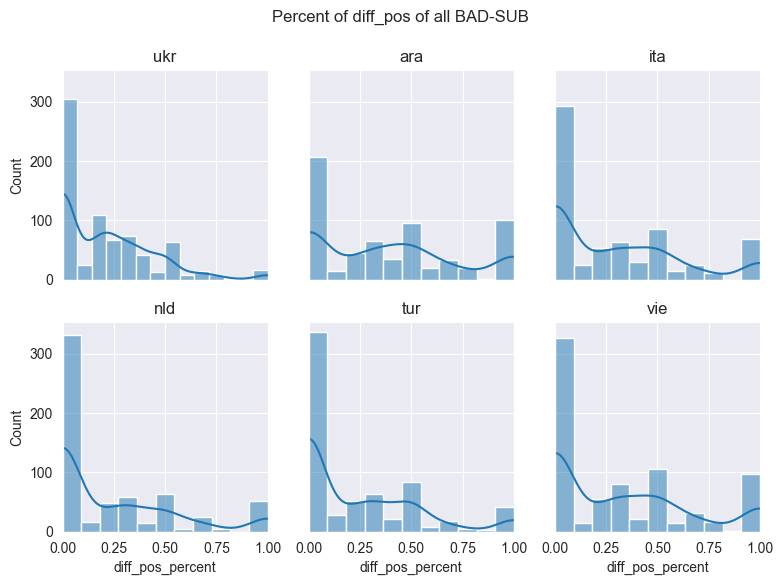

In [414]:
f, axes = plt.subplots(2, 3, figsize=(9, 6), sharex=True, sharey=True)

for ax, lang in zip(axes.flat, df['lang_id'].unique()):

    sns.histplot(
        df_stats_ext_sum.loc[(slice(None),lang), :],
        x="diff_pos_percent",
        kde=True,
        ax=ax,
    )
    ax.set_title(lang)
    # ax.set_axis_off()

ax.set(xlim=(0, 1))
f.suptitle("Percent of diff_pos of all BAD-SUB", fontsize=12)
plt.show()

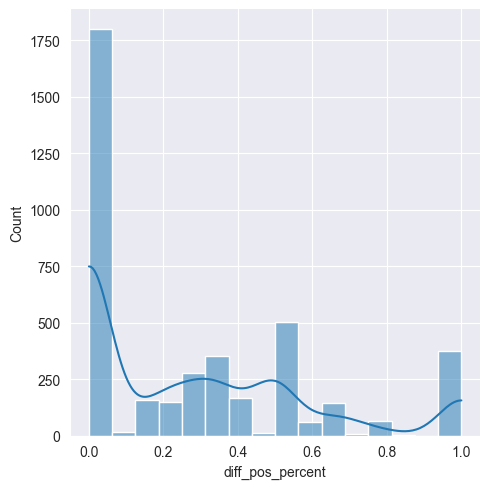

In [416]:
sns.displot(
    df_stats_ext_sum,
    x="diff_pos_percent",
    kde=True,
)

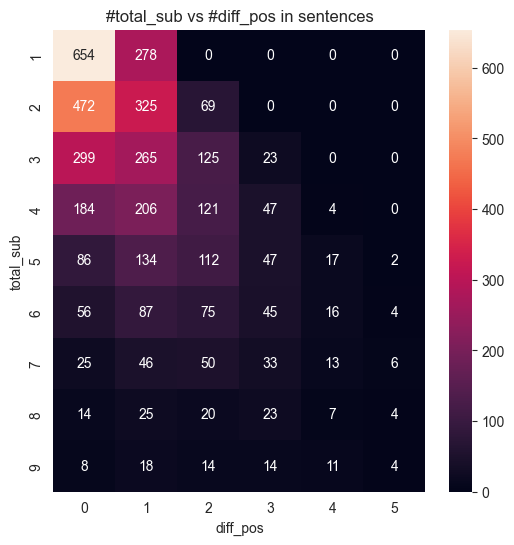

In [415]:
plt.figure(figsize=(6, 6))
sns.heatmap(
    pd.crosstab(df_stats_ext_sum['total_sub'], df_stats_ext_sum['diff_pos']),
    annot=True,
    fmt=".0f",
).set(title='#total_sub vs #diff_pos in sentences')
plt.show()

## Analyse Syntax Trees (using Stanza & Tree Edit Distance)

In [ ]:
# process saved stanza sentences to original format

def list_to_stanza_sentence(token_list, annotations_list) -> StanzaSentence:
    tokens = []
    for i, (token, anotation) in enumerate(zip(token_list, annotations_list), start=1):
        token_dict = dict(
            id=i,
            text=token,
            lemma=anotation.get('lemma'),
            upos=anotation.get('upos'),
            xpos=anotation.get('xpos'),
            feats=anotation.get('feats'),
            head=anotation.get('head'),
            deprel=anotation.get('deprel'),
            misc='start_char={}|end_char={}'.format(anotation.get('start_char'), anotation.get('end_char')),
            ner=anotation.get('ner'),
        )

        tokens.append(token_dict)

    sentence = StanzaSentence(tokens=tokens)
    return sentence

In [304]:
# use astred to calculate tree edit distance

df_synt_scores = pd.DataFrame()

langs = {
    'vie': 'vi',
    'tur': 'tr',
    'ukr': 'uk',
    'ara': 'ar',
    'ita': 'it',
    'nld': 'nl',
}

for _id, x in tqdm(df.iterrows(), total=len(df)):
    pe_tokens = eval(x['tgt_tokens'])
    pe_annotations = eval(x['tgt_annotations'])
    mt_tokens = eval(x['mt_tokens'])
    mt_annotations = eval(x['mt_annotations'])
    mt_tbd_qe = eval(x['mt_tbd_qe'])
    mt_pe_alignments_raw = eval(x['mt_pe_tbd_qe_alignments'])
    mt_pe_alignments_dict = defaultdict(list)

    for k, v, score in mt_pe_alignments_raw:
        if k is not None:
            mt_pe_alignments_dict[k].append(v)

    mt_pe_alignments_pairs = [(k, v[0]) for k, v in mt_pe_alignments_dict.items() if len(v) > 0 and v[0] is not None]

    # fix 2 sentences examples with 2 heads to be 1 headed (match to first head
    def _to_int(x, max_value = None):
        try:
            values = [int(i) for i in x.split('+')]
            if 0 in values:
                val = 0
            else:
                val = values[0]
        except AttributeError:
            val = int(x)
        if max_value:
            # fix index error when some tree indexes greater than tree length
            val = min(val, max_value)
        return val

    try:
        mt_annotations = [{**annotation, 'head': _to_int(annotation['head'], max_value=len(mt_annotations)-1)} for annotation in mt_annotations]
        first_head, *other_heads = [i for i, annotation in enumerate(mt_annotations) if annotation['head'] == 0]
        mt_annotations = [{**annotation, 'head': first_head} if i in other_heads else annotation for i, annotation in enumerate(mt_annotations)]

        pe_annotations = [{**annotation, 'head': _to_int(annotation['head'], max_value=len(pe_annotations)-1)} for annotation in pe_annotations]
        first_head, *other_heads = [i for i, annotation in enumerate(pe_annotations) if annotation['head'] == 0]
        pe_annotations = [{**annotation, 'head': first_head} if i in other_heads else annotation for i, annotation in enumerate(pe_annotations)]
    except ValueError:
        print('VALUE ERROR')
        print('mt_annotations', [i['head'] for i in mt_annotations])
        print('pe_annotations', [i['head'] for i in pe_annotations])
        _df_synt_scores = pd.DataFrame([{
            'unit_id': _id,
            'lang_id': x['lang_id'],
            'ted': None,
        }])
        df_synt_scores = pd.concat([df_synt_scores, _df_synt_scores], ignore_index=True)
        continue

    try:
        sent_mt = Sentence.from_parser(list_to_stanza_sentence(mt_tokens, mt_annotations))
        sent_pe = Sentence.from_parser(list_to_stanza_sentence(pe_tokens, pe_annotations))

        aligned = AlignedSentences(
            sent_mt,
            sent_pe,
            word_aligns=mt_pe_alignments_pairs,
        )
        ted = aligned.ted
    except IndexError:
        print('INDEX ERROR')
        print('mt_annotations', [i['head'] for i in mt_annotations])
        print('pe_annotations', [i['head'] for i in pe_annotations])
        ted = None

    _df_synt_scores = pd.DataFrame([{
        'unit_id': _id,
        'lang_id': x['lang_id'],
        'ted': int(ted),
    }])
    df_synt_scores = pd.concat([df_synt_scores, _df_synt_scores], ignore_index=True)

df_synt_scores['ted'] = df_synt_scores['ted'].astype(int)

df_synt_scores

  7%|▋         | 386/5160 [00:33<05:47, 13.72it/s]19-Jul 11:31:00 - [WARNING]: Can only create a tree for a sentence if it has one (and only one) root (Word.is_root). A tree for this sentence was not created.
19-Jul 11:31:00 - [WARNING]: Can only create a tree for a sentence if it has one (and only one) root (Word.is_root). A tree for this sentence was not created.
 14%|█▍        | 724/5160 [01:06<14:20,  5.15it/s]19-Jul 11:31:32 - [WARNING]: Can only create a tree for a sentence if it has one (and only one) root (Word.is_root). A tree for this sentence was not created.
19-Jul 11:31:32 - [WARNING]: Can only create a tree for a sentence if it has one (and only one) root (Word.is_root). A tree for this sentence was not created.
 14%|█▍        | 738/5160 [01:06<04:37, 15.93it/s]19-Jul 11:31:33 - [WARNING]: Can only create a tree for a sentence if it has one (and only one) root (Word.is_root). A tree for this sentence was not created.
19-Jul 11:31:33 - [WARNING]: Can only create a tree for

,unit_id,lang_id,ted
0,flores101-main-ukr-100-pe1-1,ukr,14
1,flores101-main-ukr-100-pe1-2,ukr,4
2,flores101-main-ukr-100-pe1-3,ukr,9
3,flores101-main-ukr-100-pe1-4,ukr,12
4,flores101-main-ukr-100-pe1-5,ukr,14
...,...,...,...
5155,flores101-main-vie-106-pe2-4,vie,16
5156,flores101-main-vie-48-pe1-1,vie,11
5157,flores101-main-vie-48-pe1-2,vie,27
5158,flores101-main-vie-48-pe1-3,vie,16


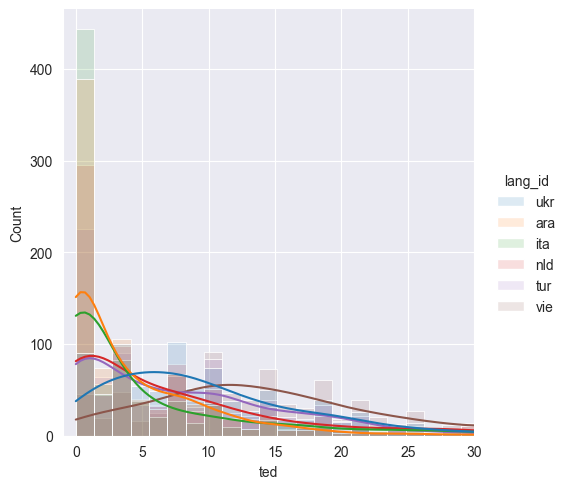

In [419]:
g = sns.displot(
    df_synt_scores,
    x="ted",
    hue="lang_id",
    kde=True,
    # log_scale=(False, 2),
    multiple="layer",
    alpha=0.15,
    # facet_kws={'hist_kws':dict(alpha=0.1)}
)
plt.xlim(-1, 30)
plt.ylim(0, None)
plt.show()

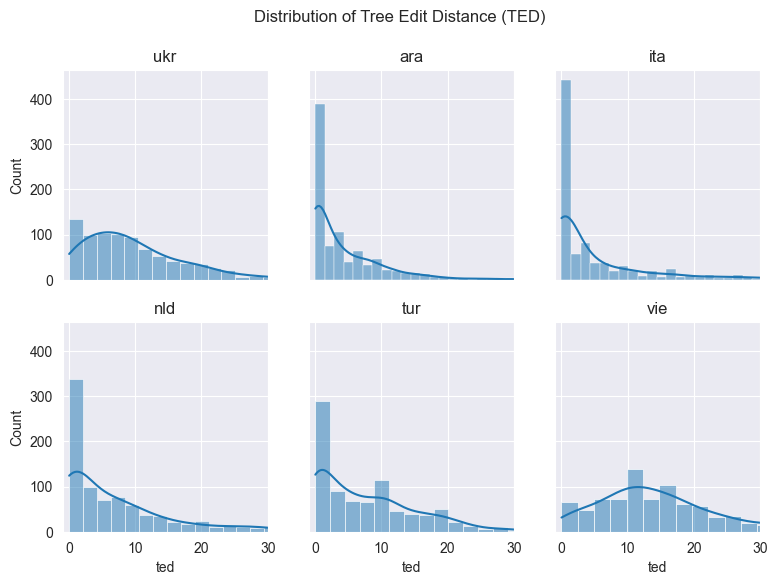

In [372]:

f, axes = plt.subplots(2, 3, figsize=(9, 6), sharex=True, sharey=True)

for ax, lang in zip(axes.flat, df['lang_id'].unique()):
    #
    # # Create a cubehelix colormap to use with kdeplot
    # cmap = sns.cubehelix_palette(start=s, light=1, as_cmap=True)

    sns.histplot(
        df_synt_scores[df_synt_scores['lang_id'] == lang],
        x="ted",
        kde=True,
        # log_scale=(False, 2),
        multiple="layer",
        # alpha=0.25,
        # facet_kws={'hist_kws':dict(alpha=0.1)}
        stat='count',
        ax=ax,
    )
    ax.set_title(lang)
    # ax.set_axis_off()

ax.set(xlim=(-1, 30))
f.suptitle("Distribution of Tree Edit Distance (TED)", fontsize=12)
plt.show()

In [309]:
df_synt_scores['mt_tbd_bad_count'] = df['mt_tbd_qe'].apply(eval).apply(lambda x: sum(len(i - {'OK', 'BAD-DEL-L', 'BAD-DEL-R', 'BAD-SHF'}) for i in x)).values
df_synt_scores.sample(5)

,unit_id,lang_id,ted,mt_tbd_bad_count
2864,flores101-main-nld-100-pe2-1,nld,11,4
433,flores101-main-ukr-5-pe2-2,ukr,2,6
4835,flores101-main-vie-93-pe1-5,vie,7,2
4776,flores101-main-vie-69-pe1-4,vie,18,2
2975,flores101-main-nld-39-pe1-5,nld,0,0


In [327]:
print('Pearson correlation')
df_synt_scores.groupby('lang_id')[['ted', 'mt_tbd_bad_count']].corr(method='pearson').loc[(slice(None),'ted'), 'mt_tbd_bad_count']

Pearson correlation


lang_id     
ara      ted    0.556922
ita      ted    0.434015
nld      ted    0.669098
tur      ted    0.689409
ukr      ted    0.710757
vie      ted    0.642947
Name: mt_tbd_bad_count, dtype: float64

Note: BAD count except for BAD-DEL and BAD-SHF


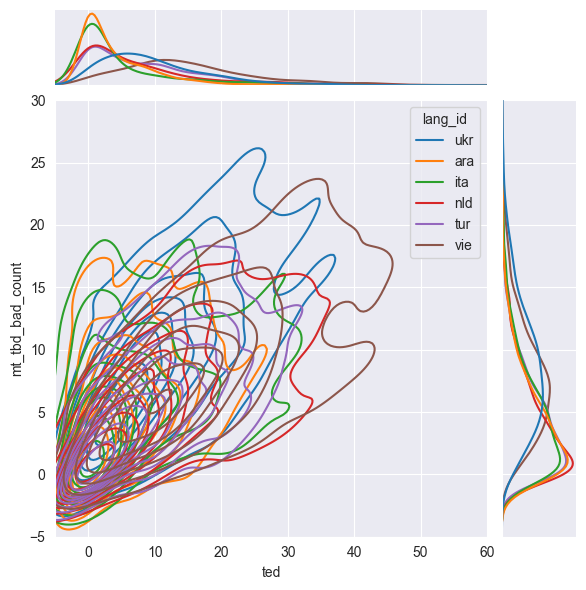

In [355]:
print('Note: BAD count except for BAD-DEL and BAD-SHF')
sns.jointplot(df_synt_scores, x="ted", y="mt_tbd_bad_count", hue="lang_id", kind="kde", fill=Fl, marginal_kws={'hist_kws':dict(alpha=0.1)})
plt.xlim(-5, 60)
plt.ylim(-5, 30)
plt.show()

Text(0.5, 0.98, 'Correlation of Tree Edit Distance (TED) vs #BAD-X tags')

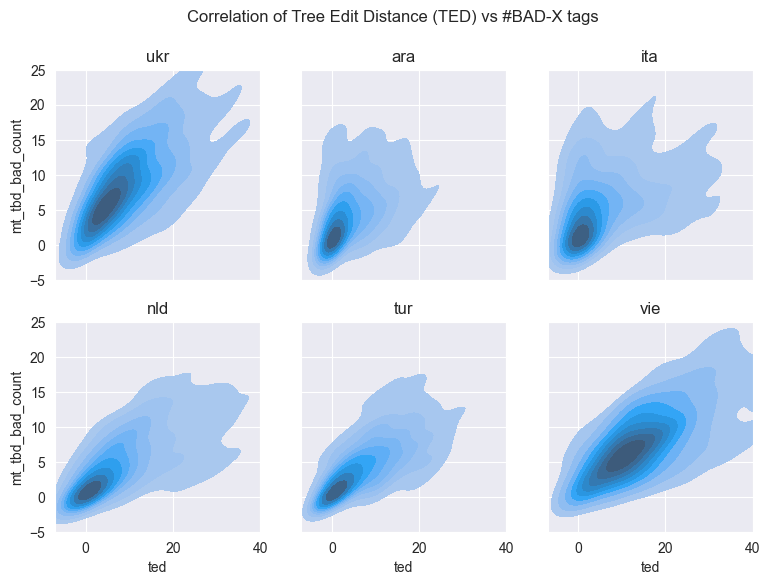

In [374]:

f, axes = plt.subplots(2, 3, figsize=(9, 6), sharex=True, sharey=True)

for ax, lang in zip(axes.flat, df['lang_id'].unique()):
    #
    # # Create a cubehelix colormap to use with kdeplot
    # cmap = sns.cubehelix_palette(start=s, light=1, as_cmap=True)

    sns.kdeplot(
        df_synt_scores[df_synt_scores['lang_id'] == lang],
        x="ted",
        y="mt_tbd_bad_count",
        # cmap=None,
        fill=True,
        # clip=(-5, 5),
        # cut=10,
        # thresh=0,
        # levels=15,
        ax=ax,
    )
    ax.set_title(lang)
    # ax.set_axis_off()

ax.set(xlim=(-7, 40), ylim=(-5, 25))
f.suptitle("Correlation of Tree Edit Distance (TED) vs #BAD-X tags", fontsize=12)
plt.show()

---

In [35]:
import matplotlib.ticker as ticker


def plot_summary_df(summary_df, title=''):
    try:
        summary_df = summary_df.drop(['TOTAL', 'AVG'], axis=0)
    except KeyError:
        pass

    sns.set_theme(style="whitegrid")
    sns.set(font_scale=1.5)

    # Make the PairGrid
    g = sns.PairGrid(
        # summary_df.reset_index().sort_values("total (same pos)", ascending=False),
        summary_df.reset_index(),
        x_vars=summary_df.columns,
        y_vars=["lang_id"],
        height=10,
        aspect=.3,
    )

    # Draw a dot plot using the stripplot function
    g.map(
        sns.stripplot,
        size=15,
        orient="h",
        jitter=False,
        palette="flare_r",
        linewidth=2,
        edgecolor="w",
    )

    if title:
        g.fig.subplots_adjust(top=0.9)
        g.fig.suptitle(title)

    # Calculate the average for each column and draw a horizontal line
    for ax, col in zip(g.axes.flat, summary_df.columns):
        avg = summary_df[col].mean()
        ax.axvline(avg, color='r', linestyle='--')

        step = 5000 if summary_df[col].max() > 10000 else 2500 if summary_df[col].max() > 5000 else 1000 if summary_df[col].max() > 2000 else 500 if summary_df[col].max() > 800 else 100 if summary_df[col].max() > 500 else 50
        ax.set_xticks(np.arange(0, summary_df[col].max(), step=step))
        ax.xaxis.set_major_formatter(ticker.EngFormatter())


    # setup axis limits
    g.set(xlim=(0, None), xlabel="Count", ylabel="")
    for ax, title in zip(g.axes.flat, list(summary_df.columns)):
        ax.set(title=title)
        ax.xaxis.grid(True)
        ax.yaxis.grid(True)

    sns.despine(left=True, bottom=True)

In [190]:
print('TOTAL:\t', len(df_stats))
print('SAME POS:\t', len(df_stats[df_stats['same_pos']]))
print('DIFF POS:\t', len(df_stats[~df_stats['same_pos']]))

tmp = pd.DataFrame([
    df_stats.groupby(['lang_id']).size(),
    df_stats[df_stats['same_pos']].groupby(['lang_id']).size(),
    df_stats[~df_stats['same_pos']].groupby(['lang_id']).size(),
    df_stats[~df_stats['same_deprel']].groupby(['lang_id']).size(),
], index=[
    'total',
    'same_pos',
    'diff_pos',
    'diff_deprel',
]).fillna(0).astype('int').T
tmp.loc['TOTAL'] = tmp.sum(numeric_only=True)
tmp.loc['AVG'] = (tmp.loc['TOTAL'] / len(set(df_stats['lang_id']) - {'TOTAL'})).astype('int')

# print(tmp)
tmp

TOTAL:	 14809
SAME POS:	 10820
DIFF POS:	 3989


,total,same_pos,diff_pos,diff_deprel
lang_id,,,,
ara,2055,1230,825,1027
ita,2368,1702,666,861
nld,1728,1301,427,600
tur,2217,1685,532,1079
ukr,4295,3425,870,1641
vie,2146,1477,669,1217
TOTAL,14809,10820,3989,6425
AVG,2468,1803,664,1070


In [193]:
tmp

,total,same_pos,diff_pos,diff_deprel
lang_id,,,,
ara,2055,1230,825,1027
ita,2368,1702,666,861
nld,1728,1301,427,600
tur,2217,1685,532,1079
ukr,4295,3425,870,1641
vie,2146,1477,669,1217
TOTAL,14809,10820,3989,6425
AVG,2468,1803,664,1070


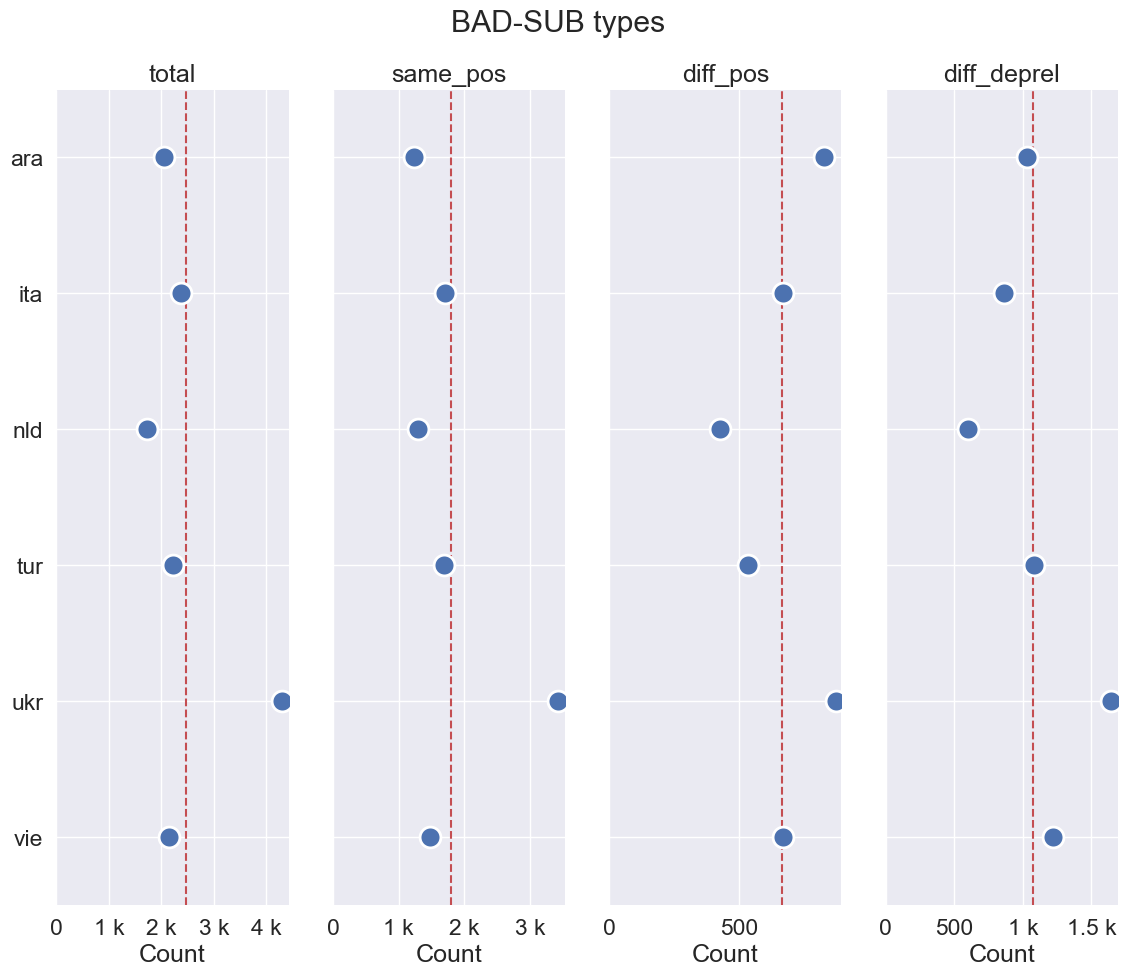

In [191]:
plot_summary_df(tmp, title='BAD-SUB types')

In [182]:
_df_stats = df_stats[df_stats['same_pos']]
print('TOTAL:\t', len(_df_stats))

tmp = pd.DataFrame([
    _df_stats.groupby(['lang_id']).size(),
    _df_stats[_df_stats['same_lemma'] & _df_stats['same_morf']].groupby(['lang_id']).size(),
    _df_stats[_df_stats['same_lemma'] & ~_df_stats['same_morf']].groupby(['lang_id']).size(),
    _df_stats[~_df_stats['same_lemma'] & _df_stats['same_morf']].groupby(['lang_id']).size(),
    _df_stats[~_df_stats['same_lemma'] & ~_df_stats['same_morf']].groupby(['lang_id']).size(),
    _df_stats[_df_stats['same_word']].groupby(['lang_id']).size(),
], index=[
    'total (same pos)',
    'same_lemma same_morf',
    'same_lemma diff_morf',
    'diff_lemma same_morf',
    'diff_lemma diff_morf',
    'same_word (diff case)',
]).fillna(0).astype('int').T
tmp.loc['TOTAL'] = tmp.sum(numeric_only=True)
tmp.loc['AVG'] = (tmp.loc['TOTAL'] / len(set(df_stats['lang_id']) - {'TOTAL'})).astype('int')

# print(tmp)
tmp

TOTAL:	 10820


,total (same pos),same_lemma same_morf,same_lemma diff_morf,diff_lemma same_morf,diff_lemma diff_morf,same_word (diff case)
lang_id,,,,,,
ara,1230,93,374,498,265,0
ita,1702,100,500,705,397,68
nld,1301,153,100,867,181,114
tur,1685,115,623,604,343,79
ukr,3425,128,1164,1067,1066,124
vie,1477,0,0,1468,9,160
TOTAL,10820,589,2761,5209,2261,545
AVG,1803,98,460,868,376,90


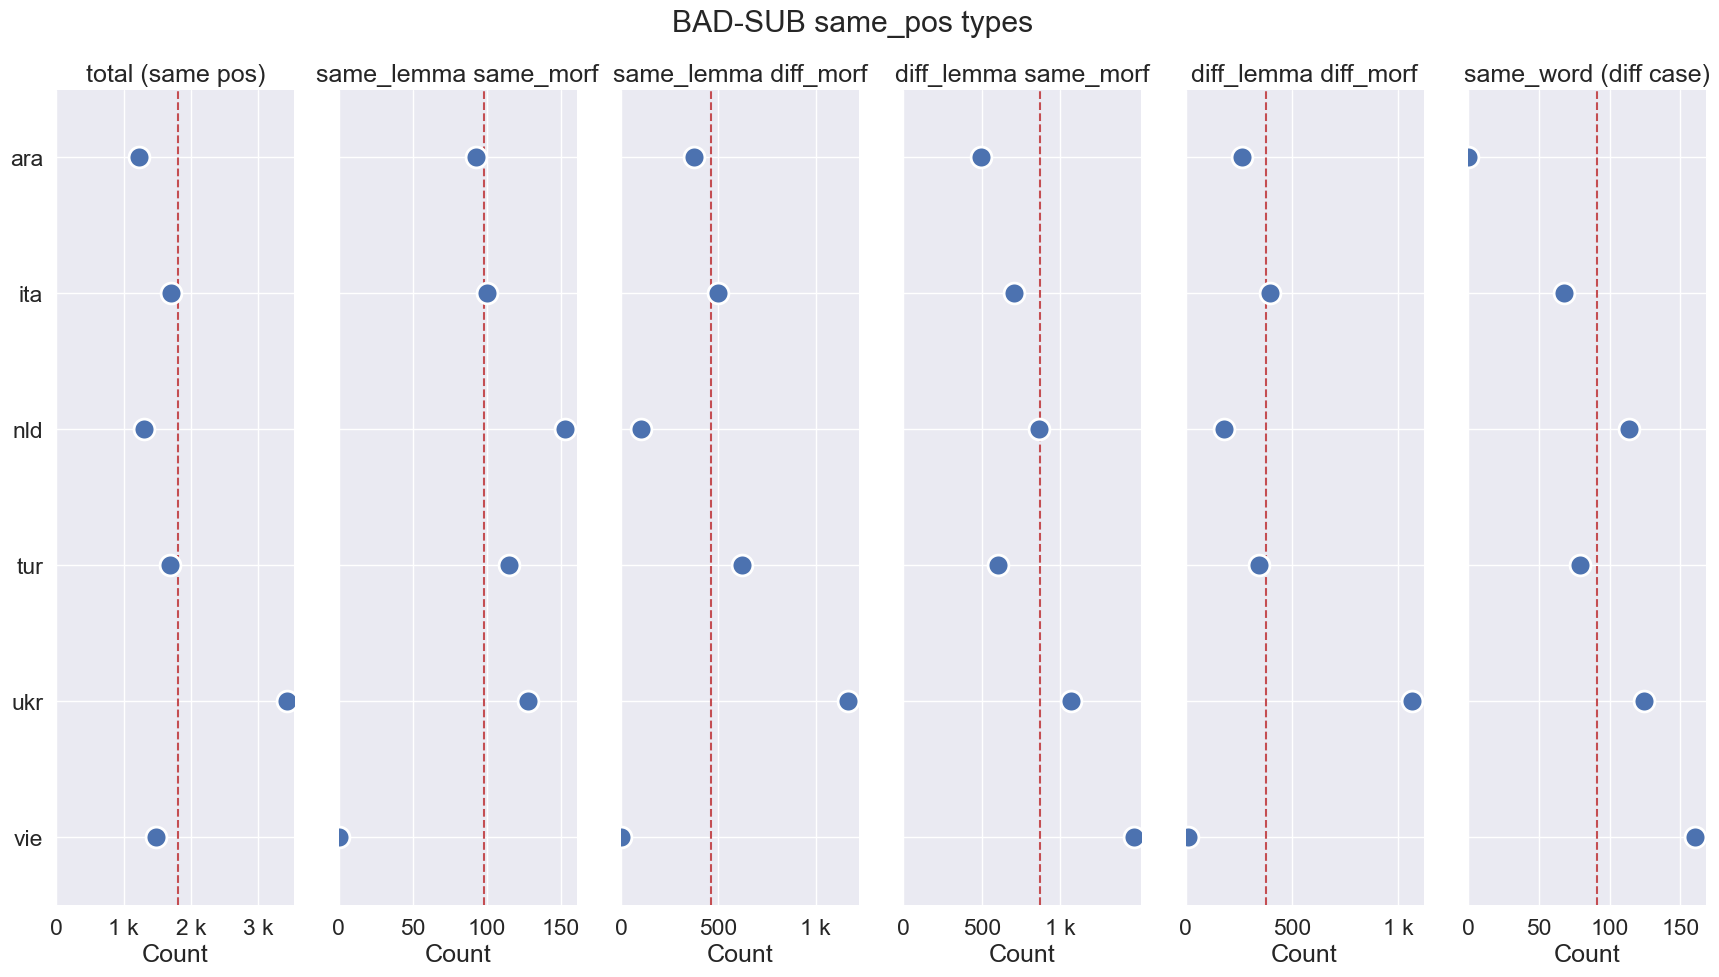

In [183]:
plot_summary_df(tmp, title='BAD-SUB same_pos types')

---